# Info

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation

# Imports

In [35]:
import kagglehub

In [36]:
import os
import glob
import tqdm
import pickle
import re
from concurrent.futures import ThreadPoolExecutor
import json

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [38]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence, plot_model

In [39]:
from sklearn.model_selection import train_test_split

# Constants

In [40]:
IMG_SHAPE_W = 224
IMG_SHAPE_H = 224

TEST_SPLIT = 0.2
VAL_SPLIT = 0.2

RONDOM_SEED = 42
np.random.seed(RONDOM_SEED)

BATCH_SIZE = 8

BASE_DIR = 'drive/MyDrive/brain_tumor_outputs'

# Functions

In [41]:
def save_obj(obj, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(obj, f)

def load_obj(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

# Dataset Downlaod

In [42]:
# Download latest version
path = kagglehub.dataset_download("nikhilroxtomar/brain-tumor-segmentation")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-segmentation


# Dataset Read

In [43]:
os.listdir(path)

['images', 'masks']

In [44]:
images_paths = glob.glob( f'{os.path.join(path, "images")}/*.*')
masks_paths = glob.glob( f'{os.path.join(path, "masks")}/*.*')

sorted(images_paths)
sorted(masks_paths)

print("Number of images:", len(images_paths))
print("Number of masks:", len(masks_paths))

Number of images: 3064
Number of masks: 3064


# Exploration & Visualization

In [45]:
N_ROWS = 5

for i in range(N_ROWS):
    path_img_i = images_paths[i]
    path_mask_i = masks_paths[i]

    img_i = cv2.imread(path_img_i, 0)
    mask_i = cv2.imread(path_mask_i, 0)

    print(f"i={i:<3} | img_i.shape={img_i.shape} | mask_i.shape={mask_i.shape}")


i=0   | img_i.shape=(512, 512) | mask_i.shape=(512, 512)
i=1   | img_i.shape=(512, 512) | mask_i.shape=(512, 512)
i=2   | img_i.shape=(512, 512) | mask_i.shape=(512, 512)
i=3   | img_i.shape=(512, 512) | mask_i.shape=(512, 512)
i=4   | img_i.shape=(512, 512) | mask_i.shape=(512, 512)


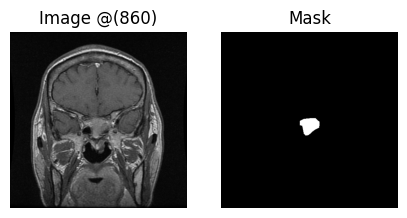

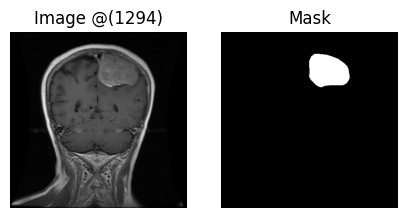

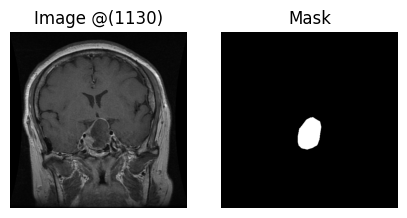

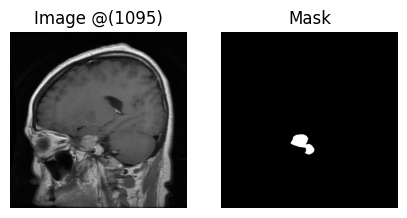

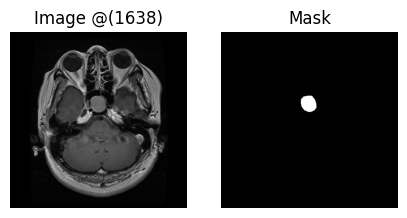

In [46]:
N_ROWS = 5

for _ in range(N_ROWS):
    random_i = np.random.randint(low=0,high=len(images_paths))

    img_path_i = images_paths[random_i]
    mask_path_i = masks_paths[random_i]

    img_i = cv2.imread(img_path_i, 0)
    mask_i = cv2.imread(mask_path_i, 0)

    plt.figure(figsize=(5, 3))

    plt.subplot(1, 2, 1)
    plt.title(f"Image @({random_i})")
    plt.imshow(img_i, cmap="gray")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Mask")
    plt.imshow(mask_i, cmap="gray")
    plt.axis('off')

    plt.show()

# Image Preprocessing

Blur

In [47]:
# # make image smooth
# def apply_filter_gaussian(image, kernel_size=(5, 5), sigma=0):
#     return cv2.GaussianBlur(image, kernel_size, sigma).astype(image.dtype)

# # remove salt and pepper noise
# def apply_filter_median(image, kernel_size=5):
#     return cv2.medianBlur(image, kernel_size).astype(image.dtype)

# # preserve edges while reducing noise
# def apply_filter_bilateral(image, d=9, sigma_color=75, sigma_space=75):
#     return cv2.bilateralFilter(image, d, sigma_color, sigma_space).astype(image.dtype)

Edge Detectors

In [48]:
def apply_laplacian(image, ksize=3):
    return cv2.Laplacian(image, cv2.CV_32F, ksize=ksize).astype(image.dtype)

def apply_sobel(image, dx=1, dy=0, ksize=3):
    return cv2.Sobel(image, cv2.CV_32F, dx, dy, ksize=ksize).astype(image.dtype)

def apply_canny(image, threshold1=50, threshold2=60):
    return cv2.Canny(image, threshold1, threshold2).astype(image.dtype)

In [49]:
def apply_canny_dir(image, threshold1=50, threshold2=60):
    grad_x = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=3)

    direction = cv2.phase(grad_x, grad_y, angleInDegrees=True)

    return cv2.Canny(direction.astype(np.uint8), threshold1, threshold2).astype(image.dtype)

Kmeans

In [50]:
def apply_kmeans(image, n_colors=12):
    n_channels = image.shape[2] if len(image.shape) == 3 else 1

    Z = image.reshape((-1, n_channels)).astype(np.float32)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, label, center = cv2.kmeans(Z, n_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    center = np.uint8(center)
    res = center[label.flatten()]
    clustered = res.reshape(image.shape)
    return clustered

proccess

In [51]:
def preprocess_image_from_path(image_path, mask_path):
    image = cv2.imread(image_path, 0)
    mask = cv2.imread(mask_path, 0)

    assert image is not None, f"Image not found at {image_path}"
    assert mask is not None, f"Mask not found at {mask_path}"

    image_channel = cv2.resize(image, (IMG_SHAPE_W, IMG_SHAPE_H))
    mask_channel = cv2.resize(mask, (IMG_SHAPE_W, IMG_SHAPE_H))

    # apply filters
    canny_0_channel = apply_canny(image_channel, 10, 25)
    canny_1_channel = apply_canny(image_channel, 35, 50)
    canny_dir_channel = apply_canny_dir(image_channel, 25, 35)

    #normalize: -1, +1
    image_channel = image_channel / 127.5 - 1.0
    canny_0_channel = canny_0_channel / 127.5 - 1.0
    canny_1_channel = canny_1_channel / 127.5 - 1.0
    canny_dir_channel = canny_dir_channel / 180 - 1.0

    mask_channel = mask_channel / 127.5 - 1.0

    mask_channel = np.where(mask_channel > 0, 1.0, -1.0)

    # stack channels
    total_img = np.stack([image_channel, canny_0_channel,canny_1_channel, canny_dir_channel], axis=-1)

    total_mask = np.expand_dims(mask_channel, axis=-1)

    total_img = total_img.astype(np.float32)
    total_mask = total_mask.astype(np.float32)

    return total_img, total_mask


In [52]:
def print_dim_images(total_img, total_mask):
  print(f"Image.shape: {total_img.shape}")
  print(f"Mask.shape: {total_mask.shape}")

  for i in range(total_img.shape[-1]):
      print(f"Img  Channel {i} min: {np.min(total_img[:, :, i]):.2f}, max: {np.max(total_img[:, :, i]):.2f}")

  for i in range(total_mask.shape[-1]):
      print(f"Mask Channel {i} min: {np.min(total_mask[:, :, i]):.2f}, max: {np.max(total_mask[:, :, i]):.2f}")

In [53]:
def plot_preprocessed_image(total_img, total_mask):
    print_dim_images(total_img, total_mask)

    fig, ax = plt.subplots(1, total_mask.shape[-1] + total_img.shape[-1]  , figsize=(10, 5))

    for i in range(total_img.shape[-1]):
        ax[i].imshow(total_img[:, :, i]  * 0.5 + 0.5, cmap="gray")
        ax[i].set_title(f"Image Channel {i}")
        ax[i].axis('off')

    for i in range(total_mask.shape[-1]):
        ax[i + total_img.shape[-1]].imshow(total_mask[:, :, i] * 0.5 + 0.5, cmap="gray")
        ax[i + total_img.shape[-1]].set_title(f"Mask Channel {i}")
        ax[i + total_img.shape[-1]].axis('off')

    plt.tight_layout()
    plt.show()

Image.shape: (224, 224, 4)
Mask.shape: (224, 224, 1)
Img  Channel 0 min: -1.00, max: 0.91
Img  Channel 1 min: -1.00, max: 1.00
Img  Channel 2 min: -1.00, max: 1.00
Img  Channel 3 min: -1.00, max: 0.42
Mask Channel 0 min: -1.00, max: 1.00


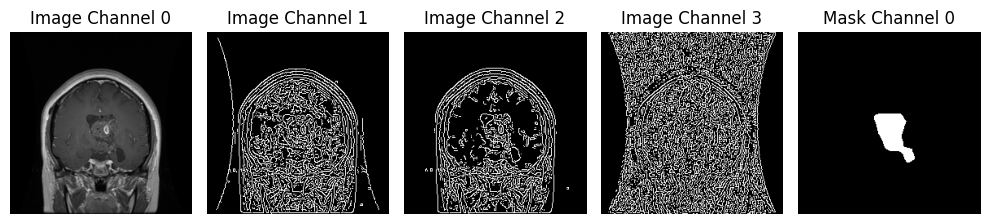

Image.shape: (224, 224, 4)
Mask.shape: (224, 224, 1)
Img  Channel 0 min: -1.00, max: 0.94
Img  Channel 1 min: -1.00, max: 1.00
Img  Channel 2 min: -1.00, max: 1.00
Img  Channel 3 min: -1.00, max: 0.42
Mask Channel 0 min: -1.00, max: 1.00


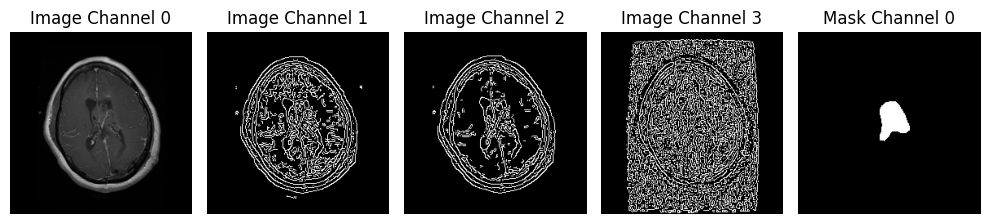

Image.shape: (224, 224, 4)
Mask.shape: (224, 224, 1)
Img  Channel 0 min: -1.00, max: 0.94
Img  Channel 1 min: -1.00, max: 1.00
Img  Channel 2 min: -1.00, max: 1.00
Img  Channel 3 min: -1.00, max: 0.42
Mask Channel 0 min: -1.00, max: 1.00


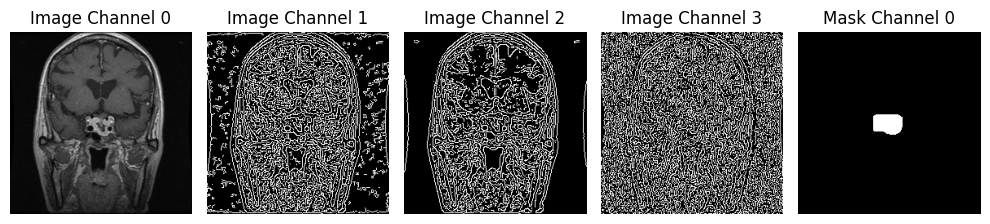

Image.shape: (224, 224, 4)
Mask.shape: (224, 224, 1)
Img  Channel 0 min: -1.00, max: 0.95
Img  Channel 1 min: -1.00, max: 1.00
Img  Channel 2 min: -1.00, max: 1.00
Img  Channel 3 min: -1.00, max: 0.42
Mask Channel 0 min: -1.00, max: 1.00


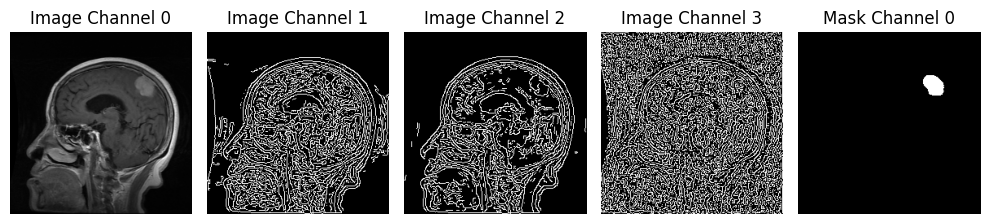

Image.shape: (224, 224, 4)
Mask.shape: (224, 224, 1)
Img  Channel 0 min: -1.00, max: 0.97
Img  Channel 1 min: -1.00, max: 1.00
Img  Channel 2 min: -1.00, max: 1.00
Img  Channel 3 min: -1.00, max: 0.42
Mask Channel 0 min: -1.00, max: 1.00


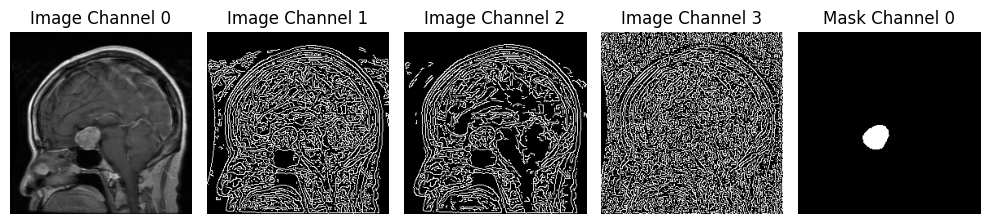

In [54]:
N_ROWS = 5


for _ in range(N_ROWS):
    random_i = np.random.randint(low=0, high=len(images_paths))

    img_path_i = images_paths[random_i]
    mask_path_i = masks_paths[random_i]

    total_img, total_mask = preprocess_image_from_path(img_path_i, mask_path_i)

    plot_preprocessed_image(total_img, total_mask)

    INPUT_IMAGE_SHAPE = total_img.shape

# Data Spliting

In [55]:
X_train_paths, X_val_paths, y_train_paths, y_val_paths = train_test_split(
    images_paths,
    masks_paths,
    test_size= TEST_SPLIT + VAL_SPLIT,
    random_state=RONDOM_SEED)

X_val_paths, X_test_paths, y_val_paths, y_test_paths = train_test_split(
    X_val_paths,
    y_val_paths,
    test_size= TEST_SPLIT / (TEST_SPLIT + VAL_SPLIT),
    random_state=RONDOM_SEED)

# Data Augmentation

In [56]:
def custom_augmentation_numpy(image, mask):
    # -----------------------------
    # 1. Random Horizontal Flip
    if np.random.rand() > 0.5:
        image = np.fliplr(image)
        mask = np.fliplr(mask)

    # # -----------------------------
    # # 2. Random Vertical Flip
    # if np.random.rand() > 0.5:
    #     image = np.flipud(image)

    # -----------------------------
    # 3. Random Rotation
    if np.random.rand() > 0.5:
        angle = np.random.uniform(-10, 10)
        h, w = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT_101, flags=cv2.INTER_LINEAR)
        mask = cv2.warpAffine(mask, M, (w, h), borderMode=cv2.BORDER_REFLECT_101, flags=cv2.INTER_NEAREST)

    # -----------------------------
    # 4. Random Crop and Resize Back
    if np.random.rand() > 0.5:
        h, w = image.shape[:2]
        crop_scale = np.random.uniform(0.92, 1.0)
        new_h, new_w = int(h * crop_scale), int(w * crop_scale)
        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)

        image = image[top:top + new_h, left:left + new_w]
        image = cv2.resize(image, (w, h))

        mask = mask[top:top + new_h, left:left + new_w]
        mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)

    # -----------------------------
    # 5. Random Brightness
    if np.random.rand() > 0.5:
        brightness_shift = np.random.uniform(-0.1, 0.1)
        image = image + brightness_shift
        image = np.clip(image, -1, 1)

    # -----------------------------
    # 6. Random Contrast
    if np.random.rand() > 0.5:
        factor = np.random.uniform(0.8, 1.2)
        mean = image.mean(axis=(0, 1), keepdims=True)
        image = (image - mean) * factor + mean
        image = np.clip(image, -1, 1)

    # -----------------------------
    # 7. Random Gaussian Noise
    if np.random.rand() > 0.5:
        noise = np.random.normal(0, 0.05, image.shape)
        image = image + noise
        image = np.clip(image, -1, 1)

    # -----------------------------
    if len(mask.shape) == 2:
        mask = np.expand_dims(mask, axis=-1)

    return image, mask

In [57]:
class MyDataGenerator(Sequence):

    generator_data_cache = dict()
    cache_len = 10_000

    def __init__(self, images_paths, masks_paths, batch_size, augment=True, shuffle=True, n_workers=4):

        self.images_paths = np.array(images_paths)
        self.masks_paths = np.array(masks_paths)

        self.batch_size = batch_size

        self.augment = augment
        self.shuffle = shuffle
        self.n_workers = n_workers

        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.images_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_images_paths = self.images_paths[batch_x]
        batch_masks_paths = self.masks_paths[batch_x]

        batch_inputs = self._load_images_parallel(batch_images_paths, batch_masks_paths)

        if self.augment:
            batch_inputs = [custom_augmentation_numpy(img, mask) for img, mask in batch_inputs]

        return np.array([x[0] for x in batch_inputs]), np.array([x[1] for x in batch_inputs])

    def on_epoch_end(self):
        self.indices = np.arange(len(self.images_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def _load_images_parallel(self, images_paths, masks_paths):
        with ThreadPoolExecutor(max_workers=self.n_workers) as executor:
            images = list(executor.map(self._load_and_preprocess_single, images_paths, masks_paths))
        return images

    def _load_and_preprocess_single(self, img_path, mask_path):
        cache_key = f"{img_path}<->{mask_path}"

        if cache_key in MyDataGenerator.generator_data_cache:
            return MyDataGenerator.generator_data_cache[cache_key]
        else:
            return_val = preprocess_image_from_path(img_path, mask_path)

            if MyDataGenerator.cache_len is None or len(MyDataGenerator.generator_data_cache) < MyDataGenerator.cache_len:
                MyDataGenerator.generator_data_cache[cache_key] = return_val

            return return_val

In [58]:
train_generator = MyDataGenerator(X_train_paths, y_train_paths, batch_size=BATCH_SIZE, augment=True, shuffle=True)
train_ordered_generator = MyDataGenerator(X_train_paths, y_train_paths, batch_size=BATCH_SIZE, augment=False, shuffle=False)

val_generator = MyDataGenerator(X_val_paths, y_val_paths, batch_size=BATCH_SIZE, augment=False, shuffle=False)

test_generator = MyDataGenerator(X_test_paths, y_test_paths, batch_size=BATCH_SIZE, augment=False, shuffle=False)

Image.shape: (224, 224, 4)
Mask.shape: (224, 224, 1)
Img  Channel 0 min: -1.00, max: 0.66
Img  Channel 1 min: -1.00, max: 1.00
Img  Channel 2 min: -1.00, max: 1.00
Img  Channel 3 min: -1.00, max: 0.42
Mask Channel 0 min: -1.00, max: 1.00


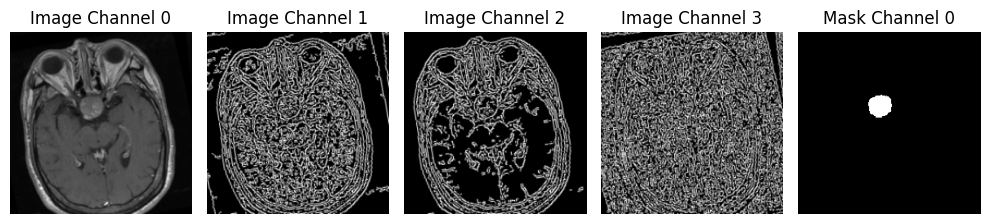

Image.shape: (224, 224, 4)
Mask.shape: (224, 224, 1)
Img  Channel 0 min: -1.00, max: 0.43
Img  Channel 1 min: -1.00, max: 0.75
Img  Channel 2 min: -1.00, max: 0.71
Img  Channel 3 min: -1.00, max: 0.30
Mask Channel 0 min: -1.00, max: 1.00


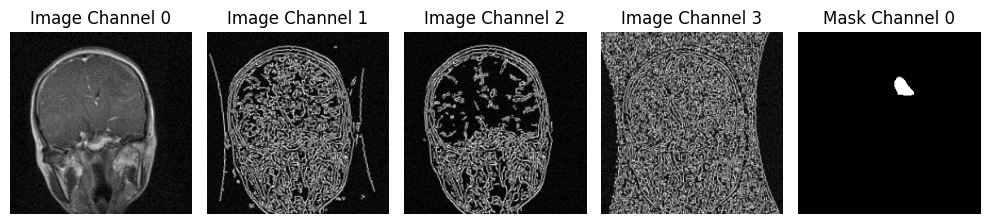

Image.shape: (224, 224, 4)
Mask.shape: (224, 224, 1)
Img  Channel 0 min: -0.98, max: 0.47
Img  Channel 1 min: -0.98, max: 0.74
Img  Channel 2 min: -0.98, max: 0.73
Img  Channel 3 min: -0.95, max: 0.26
Mask Channel 0 min: -1.00, max: 1.00


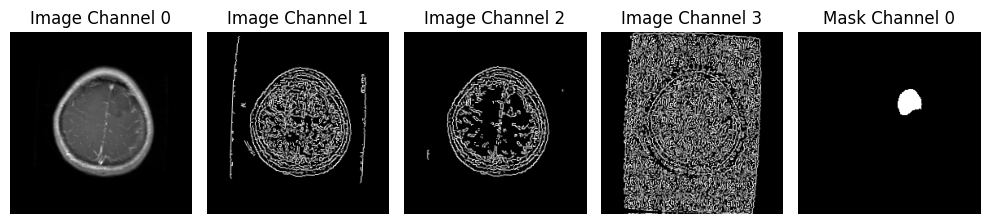

In [59]:
batch_x, batch_y = train_generator[0]

for i in range(3):
    plot_preprocessed_image(batch_x[i], batch_y[i])

# Model Encapsulation

In [60]:
CACHE_MODELS_DIR_NAME = os.path.join(BASE_DIR, 'models_cache')
os.makedirs(CACHE_MODELS_DIR_NAME, exist_ok=True)

In [61]:
class HistoryCheckpoint(Callback):
    def __init__(self, model_name):
        super().__init__()
        self.model_name = model_name
        self.filepath = os.path.join(CACHE_MODELS_DIR_NAME, f'{model_name}.history.json')
        self.history = {}

        if os.path.exists(self.filepath):
            with open(self.filepath, 'r') as f:
                self.history = json.load(f)
                print(F'Model {self.model_name} history loaded from cache')
        else:
            self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for key, value in logs.items():
            self.history.setdefault(key, []).append(float(value))

        with open(self.filepath, 'w') as f:
            json.dump(self.history, f)

    def get_history(self):
        return self.history

In [62]:
class CustomModel:
    def __init__(self, name, model):
        self.name = re.sub('[^A-Za-z0-9]', '_', str(name)).lower()

        self.model = model
        self.trained = False
        self._history = {}

        self.load()

    def fit(self, data_gen, validation_data, epochs, batch_size, force_train= False):
        file_path = CACHE_MODELS_DIR_NAME + '/' + self.name + '.weights.h5'

        es = EarlyStopping(
            monitor='val_loss',
            patience=5,
            verbose=1,
            restore_best_weights=True
        )

        mcp = ModelCheckpoint(
            filepath=file_path,
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=True,
            mode='min',
            verbose=1
        )

        rop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)

        hcp = HistoryCheckpoint(self.name)

        if self.trained == False or force_train:
            self.model.fit(data_gen,
                validation_data = validation_data,
                callbacks=[es, mcp, rop, hcp],
                epochs = epochs,
                batch_size = batch_size)

            self.trained = True
            self._history = hcp.get_history()
        else:
             self._history = hcp.get_history()


    @property
    def history(self):
        return self._history

    def load(self):
        file_path = CACHE_MODELS_DIR_NAME + '/' + self.name + '.weights.h5'

        if os.path.exists(file_path):
            self.model.load_weights(file_path)
            self.trained = True
            print(F'Model {self.name} weights loaded from cache')
        else:
            self.trained = False
            print(F'Model {self.name} weights not found in cache, training required')

# Training Loss & Metrics

In [63]:
def dice_coefficient(y_true, y_pred, smooth = 1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    # Rescale both to [0, 1]
    y_true_f = (y_true_f + 1.0) / 2.0
    y_pred_f = (y_pred_f + 1.0) / 2.0

    intersection = K.sum(y_true_f * y_pred_f)

    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def iou_metric(y_true, y_pred, smooth = 1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    # Rescale both to [0, 1]
    y_true_f = (y_true_f + 1.0) / 2.0
    y_pred_f = (y_pred_f + 1.0) / 2.0

    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection

    return (intersection + smooth) / (union + smooth)

# Models Arch

List

In [118]:
models_list = []

Blocks

In [119]:
def ConvBlock(x, filters_list, kernel_size=(3, 3), strides = (1,1), activation='relu', padding='same', use_bn=True, skip_connection=False, dropout_rate=0.1):
    shortcut = x

    for filters in filters_list:
        x = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
        if use_bn:
            x = BatchNormalization()(x)
        x = Activation(activation)(x)

    if skip_connection:
        x = Concatenate(axis=-1)([x, shortcut])

    if dropout_rate > 0.0:
        x = Dropout(dropout_rate)(x)

    return x

def SE_block(x, reduction=16):
    filters = int(x.shape[-1])

    se = GlobalAveragePooling2D()(x)
    se = Dense(filters // reduction, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)

    se = Reshape((1, 1, filters))(se)

    return Multiply()([x, se])

In [120]:
def build_model_1():
    NAME = 'unet_v1'
    inputs = Input(shape=INPUT_IMAGE_SHAPE)

    # Encoder
    c1 = ConvBlock(inputs, [32, 32], use_bn=False, skip_connection=False, dropout_rate=0.1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = ConvBlock(p1, [64, 64], use_bn=False, skip_connection=False, dropout_rate=0.1)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = ConvBlock(p2, [128, 128], use_bn=True, skip_connection=False, dropout_rate=0.1)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = ConvBlock(p3, [256, 256], use_bn=True, skip_connection=False, dropout_rate=0.1)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    b = ConvBlock(p4, [512], use_bn=True, skip_connection=True, dropout_rate=0.1)
    b = SE_block(b, reduction=16)
    b = ConvBlock(b, [512], use_bn=True, skip_connection=True, dropout_rate=0.1)

    # Decoder
    u3 = UpSampling2D((2, 2))(b)
    d1 = ConvBlock(u3, [256], use_bn=True, skip_connection=False, dropout_rate=0.1)
    d1 = Concatenate(axis=-1)([d1, c4])
    d1 = ConvBlock(d1, [256], use_bn=True, skip_connection=False, dropout_rate=0.1)

    u2 = UpSampling2D((2, 2))(d1)
    d2 = ConvBlock(u2, [128], use_bn=True, skip_connection=False, dropout_rate=0.1)
    d2 = Concatenate(axis=-1)([d2, c3])
    d2 = ConvBlock(d2, [128], use_bn=True, skip_connection=False, dropout_rate=0.1)

    u1 = UpSampling2D((2, 2))(d2)
    d3 = ConvBlock(u1, [64], use_bn=True, skip_connection=False, dropout_rate=0.1)
    d3 = Concatenate(axis=-1)([d3, c2])
    d3 = ConvBlock(d3, [64], use_bn=True, skip_connection=False, dropout_rate=0.1)

    u0 = UpSampling2D((2, 2))(d3)
    d4 = ConvBlock(u0, [32], use_bn=True, skip_connection=False, dropout_rate=0.1)
    d4 = Concatenate(axis=-1)([d4, c1])
    d4 = ConvBlock(d4, [32], use_bn=True, skip_connection=False, dropout_rate=0.1)

    outputs = Conv2D(1, (1, 1), activation='tanh')(d4)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coefficient, iou_metric])

    return CustomModel(NAME, model)

models_list.append(build_model_1())
models_list[-1].model.summary()


Model unet_v1 weights loaded from cache


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 142 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 224, 224,  │      1,184 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_36       │ (None, 224, 224,  │          0 │ conv2d_38[0][0]   │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 224, 224,  │      9,248 │ activation_36[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_37       │ (None, 224, 224,  │          0 │ conv2d_39[0][0]   │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 224, 224,  │          0 │ activation_37[0]… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 112, 112,  │          0 │ dropout_28[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 112, 112,  │     18,496 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_38       │ (None, 112, 112,  │          0 │ conv2d_40[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 112, 112,  │     36,928 │ activation_38[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_39       │ (None, 112, 112,  │          0 │ conv2d_41[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 112, 112,  │          0 │ activation_39[0]… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 56, 56,    │          0 │ dropout_29[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 56, 56,    │     73,856 │ max_pooling2d_9[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_40       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 56, 56,    │    147,584 │ activation_40[0]

 Total params: 10,881,617 (41.51 MB)

 Trainable params: 10,876,113 (41.49 MB)

 Non-trainable params: 5,504 (21.50 KB)

Plot

In [121]:
def build_model_2():
    NAME = 'unet_v2'
    inputs = Input(shape=INPUT_IMAGE_SHAPE)

    # Encoder
    c1 = ConvBlock(inputs, [32, 32], use_bn=False, skip_connection=False, dropout_rate=0.1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = ConvBlock(p1, [64, 64], use_bn=False, skip_connection=False, dropout_rate=0.1)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = ConvBlock(p2, [128, 128], use_bn=True, skip_connection=False, dropout_rate=0.1)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = ConvBlock(p3, [256, 256], use_bn=True, skip_connection=False, dropout_rate=0.1)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    b = ConvBlock(p4, [512], use_bn=True, skip_connection=True, dropout_rate=0.1)
    b = SE_block(b, reduction=16)
    b = ConvBlock(b, [512], use_bn=True, skip_connection=True, dropout_rate=0.1)
    b = SE_block(b, reduction=16)
    b = ConvBlock(b, [512], use_bn=True, skip_connection=True, dropout_rate=0.1)

    # Decoder
    u3 = Conv2DTranspose(256, (3,3), strides=(2,2), padding='same')(b)
    d1 = ConvBlock(u3, [256], use_bn=True, skip_connection=False, dropout_rate=0.1)
    d1 = Concatenate(axis=-1)([d1, c4])
    d1 = ConvBlock(d1, [256], use_bn=True, skip_connection=False, dropout_rate=0.1)
    d1 = SE_block(d1, reduction=16)

    u2 = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(d1)
    d2 = ConvBlock(u2, [128], use_bn=True, skip_connection=False, dropout_rate=0.1)
    d2 = Concatenate(axis=-1)([d2, c3])
    d2 = ConvBlock(d2, [128], use_bn=True, skip_connection=False, dropout_rate=0.1)
    d2 = SE_block(d2, reduction=16)

    u1 = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same')(d2)
    d3 = ConvBlock(u1, [64], use_bn=True, skip_connection=False, dropout_rate=0.1)
    d3 = Concatenate(axis=-1)([d3, c2])
    d3 = ConvBlock(d3, [64], use_bn=True, skip_connection=False, dropout_rate=0.1)
    d3 = SE_block(d3, reduction=16)

    u0 = Conv2DTranspose(32, (3,3), strides=(2,2), padding='same')(d3)
    d4 = ConvBlock(u0, [32], use_bn=True, skip_connection=False, dropout_rate=0.1)
    d4 = Concatenate(axis=-1)([d4, c1])
    d4 = ConvBlock(d4, [32], use_bn=True, skip_connection=False, dropout_rate=0.1)

    outputs = Conv2D(1, (1, 1), activation='tanh')(d4)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coefficient, iou_metric])

    return CustomModel(NAME, model)

models_list.append(build_model_2())
models_list[-1].model.summary()


Model unet_v2 weights not found in cache, training required


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 224, 224,  │      1,184 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_54       │ (None, 224, 224,  │          0 │ conv2d_57[0][0]   │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 224, 224,  │      9,248 │ activation_54[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_55       │ (None, 224, 224,  │          0 │ conv2d_58[0][0]   │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_42          │ (None, 224, 224,  │          0 │ activation_55[0]… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 112, 112,  │          0 │ dropout_42[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 112, 112,  │     18,496 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_56       │ (None, 112, 112,  │          0 │ conv2d_59[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 112, 112,  │     36,928 │ activation_56[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_57       │ (None, 112, 112,  │          0 │ conv2d_60[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_43          │ (None, 112, 112,  │          0 │ activation_57[0]… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 56, 56,    │          0 │ dropout_43[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 56, 56,    │     73,856 │ max_pooling2d_13… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_61[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_58       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 56, 56,    │    147,584 │ activation_58[0]

 Total params: 18,963,293 (72.34 MB)

 Trainable params: 18,956,765 (72.31 MB)

 Non-trainable params: 6,528 (25.50 KB)

In [122]:
for model in models_list:
          keras_model = model.model

          img_path = os.path.join(CACHE_MODELS_DIR_NAME,f'{model.name}_arch.png')

          plot_model(
              keras_model,
              to_file= img_path,
              show_shapes=True,
              dpi =200,
              show_layer_names=True,
              expand_nested=True,
              show_layer_activations=True,
              show_trainable=True,
              show_dtype=True,
          )

# Train

In [123]:
for i, model in enumerate(models_list):
    print(f"{i+1}. Train: {model.name}")
    model.fit(train_generator, val_generator, epochs=70, batch_size=BATCH_SIZE, force_train=False)
    print('\n')

1. Train: unet_v1
Model unet_v1 history loaded from cache


2. Train: unet_v2
Epoch 1/70


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_270']
Received: inputs=Tensor(shape=(None, 224, 224, 4))
  warnings.warn(msg)


230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - dice_coefficient: 0.1422 - iou_metric: 0.0810 - loss: 0.8577
Epoch 1: val_loss improved from inf to 0.90048, saving model to drive/MyDrive/brain_tumor_outputs/models_cache/unet_v2.weights.h5
230/230 ━━━━━━━━━━━━━━━━━━━━ 143s 402ms/step - dice_coefficient: 0.1427 - iou_metric: 0.0813 - loss: 0.8572 - val_dice_coefficient: 0.0991 - val_iou_metric: 0.0554 - val_loss: 0.9005 - learning_rate: 0.0010
Epoch 2/70
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - dice_coefficient: 0.4389 - iou_metric: 0.2897 - loss: 0.5615
Epoch 2: val_loss improved from 0.90048 to 0.57510, saving model to drive/MyDrive/brain_tumor_outputs/models_cache/unet_v2.weights.h5
230/230 ━━━━━━━━━━━━━━━━━━━━ 68s 229ms/step - dice_coefficient: 0.4390 - iou_metric: 0.2898 - loss: 0.5614 - val_dice_coefficient: 0.4248 - val_iou_metric: 0.2762 - val_loss: 0.5751 - learning_rate: 0.0010
Epoch 3/70
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - dice_coefficient: 0.4952 - iou_metric: 0.339

# History

In [124]:
plt.style.use(plt.style.available[12])

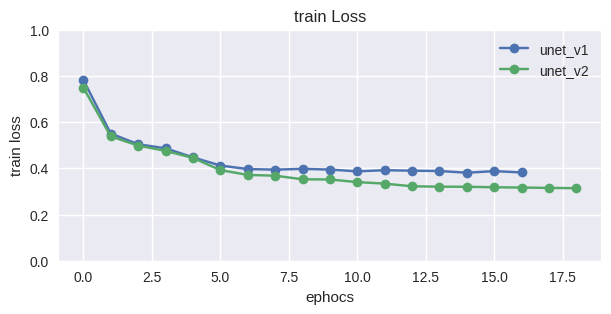

In [134]:
plt.figure(figsize=(7,3))

for model in models_list:
    plt.plot(model.history['loss'], label=f'{model.name}', marker='o')

plt.title('train Loss')
plt.ylabel('train loss')
plt.xlabel('ephocs')
plt.ylim(0, 1.0)
plt.legend()
plt.show()


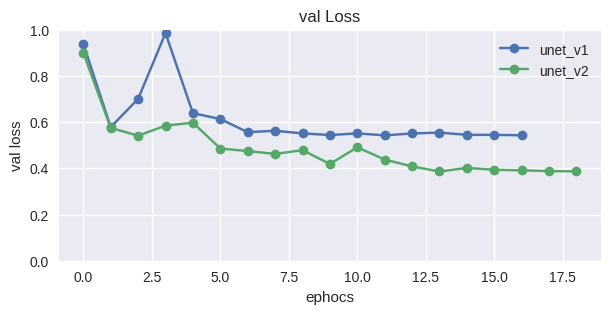

In [135]:
plt.figure(figsize=(7,3))

for model in models_list:
    plt.plot(model.history['val_loss'], label=f'{model.name}', marker='o')

plt.title('val Loss')
plt.ylabel('val loss')
plt.xlabel('ephocs')
plt.ylim(0, 1.0)
plt.legend()
plt.show()


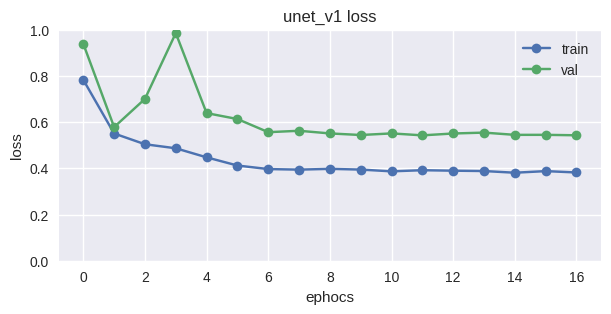

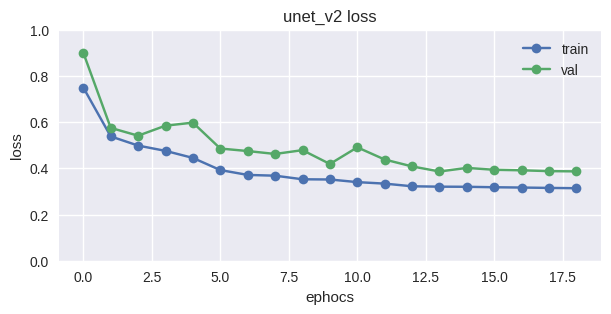

In [125]:
for i, model in enumerate(models_list):
    plt.figure(figsize=(7,3))
    plt.grid(True)
    plt.title(f"{model.name} loss")
    plt.ylabel('loss')
    plt.xlabel('ephocs')
    plt.plot(model.history['loss'], label='train', marker = 'o')
    plt.plot(model.history['val_loss'], label='val', marker = 'o')
    plt.ylim(0, 1.0)
    plt.legend()
    plt.show()

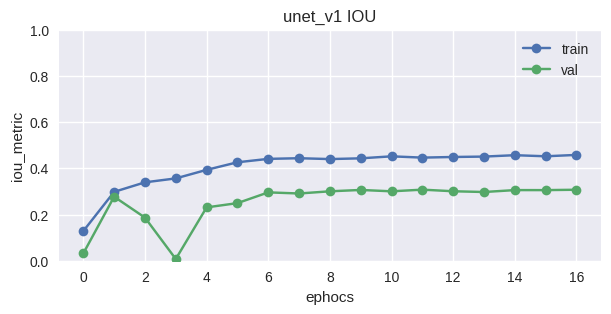

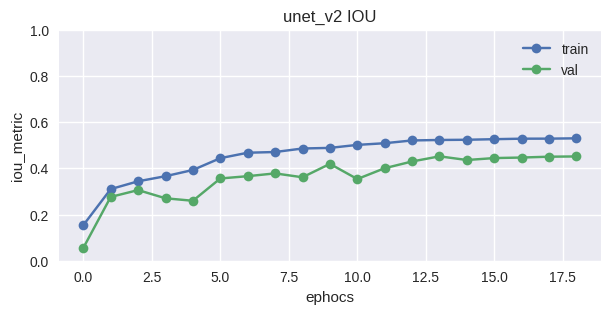

In [126]:
for i, model in enumerate(models_list):
    plt.figure(figsize=(7,3))
    plt.grid(True)
    plt.title(f"{model.name} IOU")
    plt.ylabel('iou_metric')
    plt.xlabel('ephocs')
    plt.plot(model.history['iou_metric'], label='train', marker = 'o')
    plt.plot(model.history['val_iou_metric'], label='val', marker = 'o')
    plt.legend()
    plt.ylim([0, 1])
    plt.show()

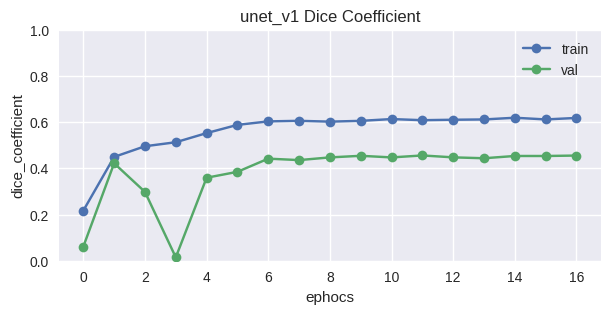

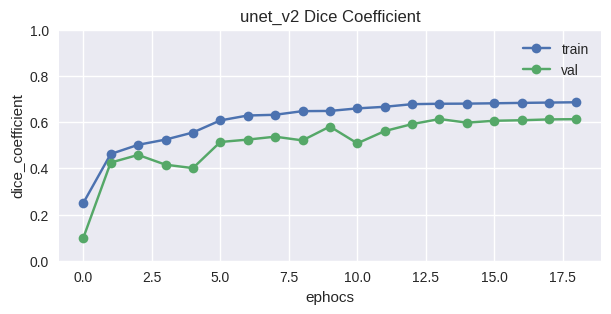

In [127]:
for i, model in enumerate(models_list):
    plt.figure(figsize=(7,3))
    plt.grid(True)
    plt.title(f"{model.name} Dice Coefficient")
    plt.ylabel('dice_coefficient')
    plt.xlabel('ephocs')
    plt.plot(model.history['dice_coefficient'], label='train', marker = 'o')
    plt.plot(model.history['val_dice_coefficient'], label='val', marker = 'o')
    plt.legend()
    plt.ylim([0, 1])
    plt.show()

# Evaluation

In [128]:
for model in models_list:
    outputs = model.model.evaluate(test_generator)

    print(f"model: {model.name}")
    print(f"test loss: {outputs[0]}")
    print(f"test dice_coefficient: {outputs[1]}")
    print(f"test iou_metric: {outputs[2]}")
    print("\n")

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_185']
Received: inputs=Tensor(shape=(None, 224, 224, 4))
  warnings.warn(msg)


77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - dice_coefficient: 0.4819 - iou_metric: 0.3293 - loss: 0.5181
model: unet_v1
test loss: 0.5276253819465637
test dice_coefficient: 0.47414669394493103
test iou_metric: 0.32482993602752686


77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - dice_coefficient: 0.6253 - iou_metric: 0.4663 - loss: 0.3747
model: unet_v2
test loss: 0.3803139925003052
test dice_coefficient: 0.6208811402320862
test iou_metric: 0.4618404507637024




# Test

In [195]:
def test_models(data_gen, label=''):
  N_ROWS = 2

  for i, model in enumerate(models_list):
      for j in range(N_ROWS):
          fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 4))

          batch_j = np.random.randint(0, len(data_gen))
          idx = np.random.randint(0, BATCH_SIZE)

          batch_x, batch_y = data_gen[batch_j]

          x = batch_x[[idx]]
          y = batch_y[[idx]]
          y_pred = model.model.predict(x, verbose=0)

          x = x[0,:,:,0] * 0.5 + 0.5
          y = y[0] * 0.5 + 0.5
          y_pred = y_pred[0] * 0.5 + 0.5

          y = np.where(y > 0.5, 1, 0)
          y_pred = np.where(y_pred > 0.5, 1, 0)

          x_plus_y = cv2.cvtColor(x, cv2.COLOR_GRAY2RGB)
          x_plus_y = np.where(y > 0.5, (1.0, 0.0, 0.0), x_plus_y)

          x_plut_y_pred = cv2.cvtColor(x, cv2.COLOR_GRAY2RGB)
          x_plut_y_pred = np.where(y_pred > 0.5, (1.0, 0.0, 0.0), x_plut_y_pred)

          axes[0].imshow(x, cmap='gray')
          axes[0].set_title('Input Image')
          axes[0].axis('off')

          axes[1].imshow(y, cmap='gray')
          axes[1].set_title('Mask')
          axes[1].axis('off')

          axes[2].imshow(x_plus_y)
          axes[2].set_title('Input Image + Mask')
          axes[2].axis('off')

          axes[3].imshow(y_pred, cmap='gray')
          axes[3].set_title('Prediction')
          axes[3].axis('off')

          axes[4].imshow(x_plut_y_pred)
          axes[4].set_title('Input Image + Prediction')
          axes[4].axis('off')

          axes[5].imshow(np.abs((y) - (y_pred)), cmap='gray')
          axes[5].set_title('Difference')
          axes[5].axis('off')

          fig.suptitle(f"Model: {model.name}. {label}")
          plt.show()


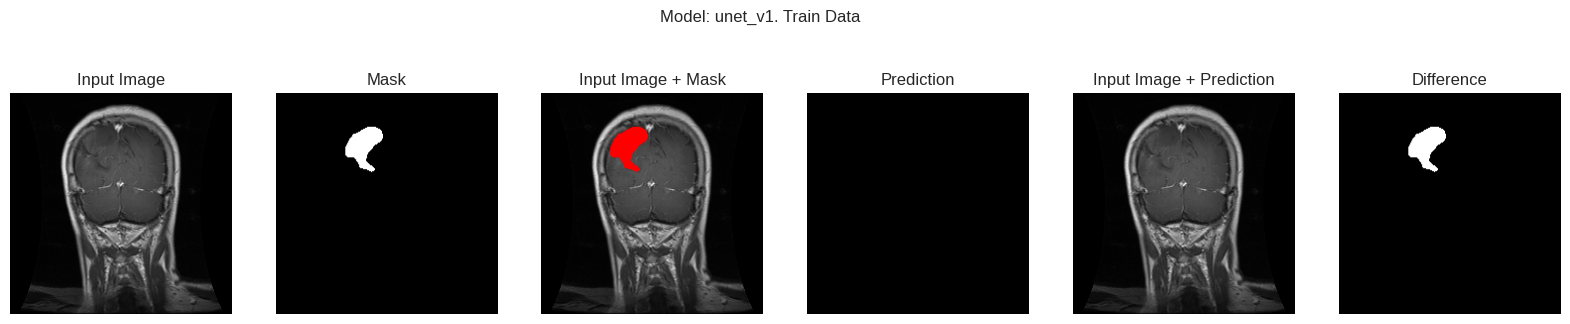

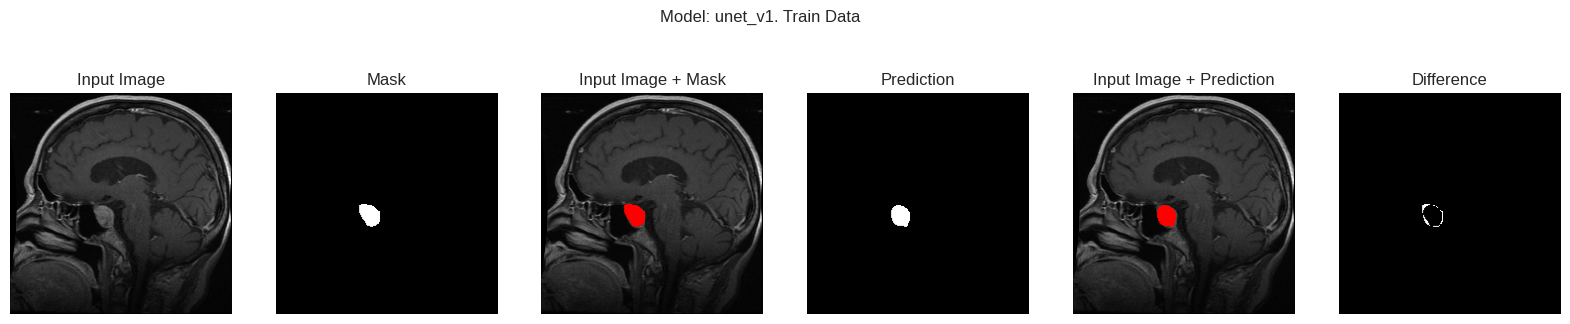

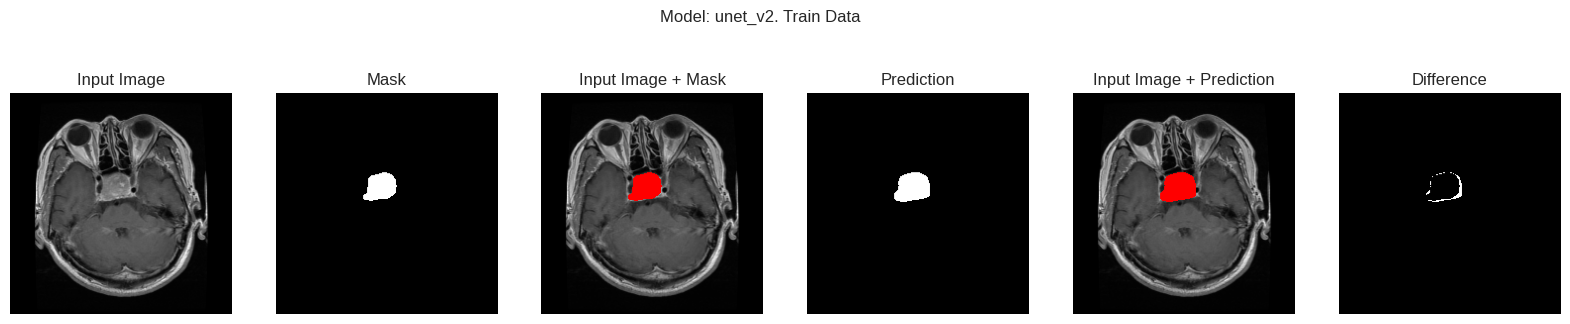

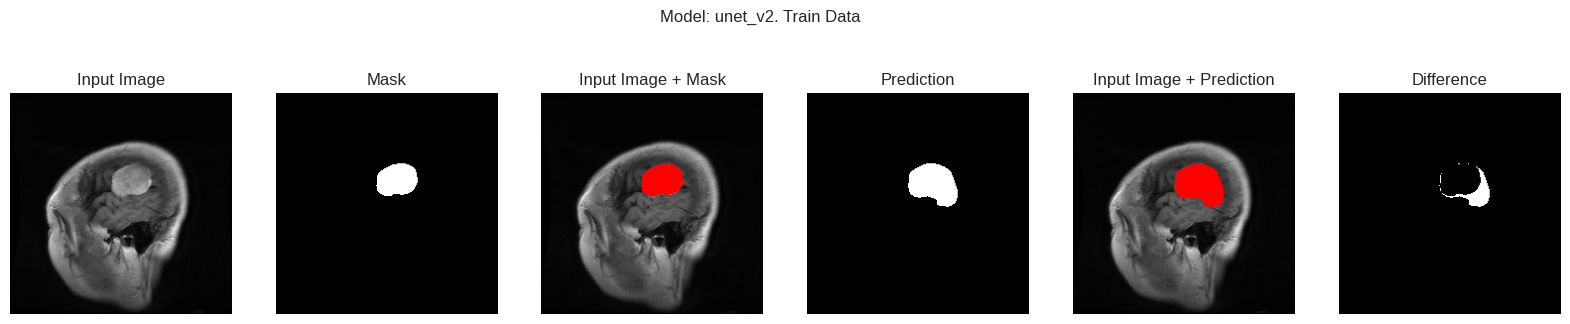

In [196]:
test_models(train_ordered_generator, "Train Data")

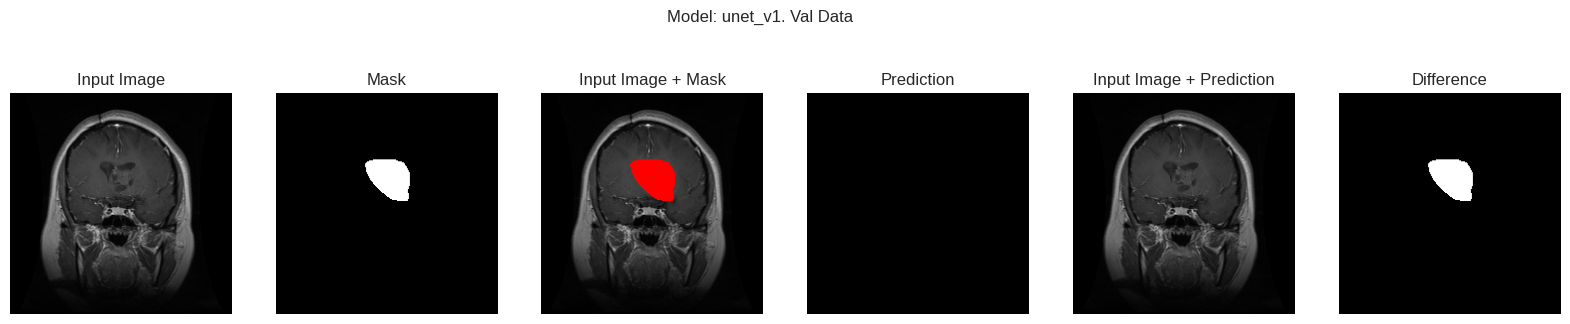

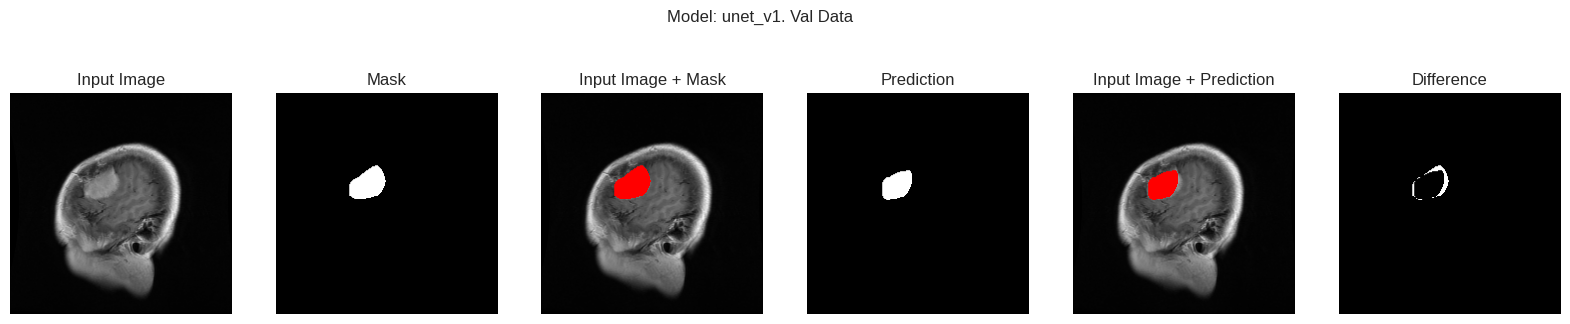

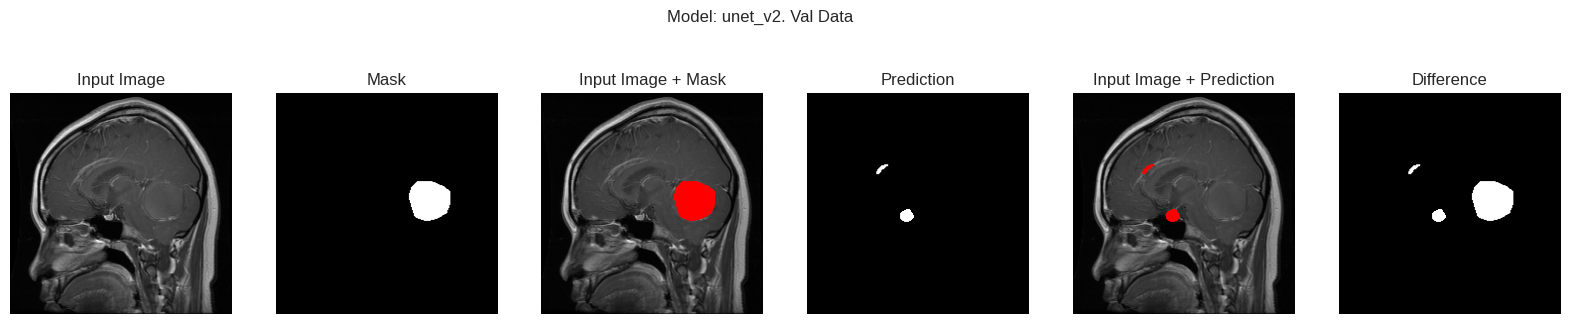

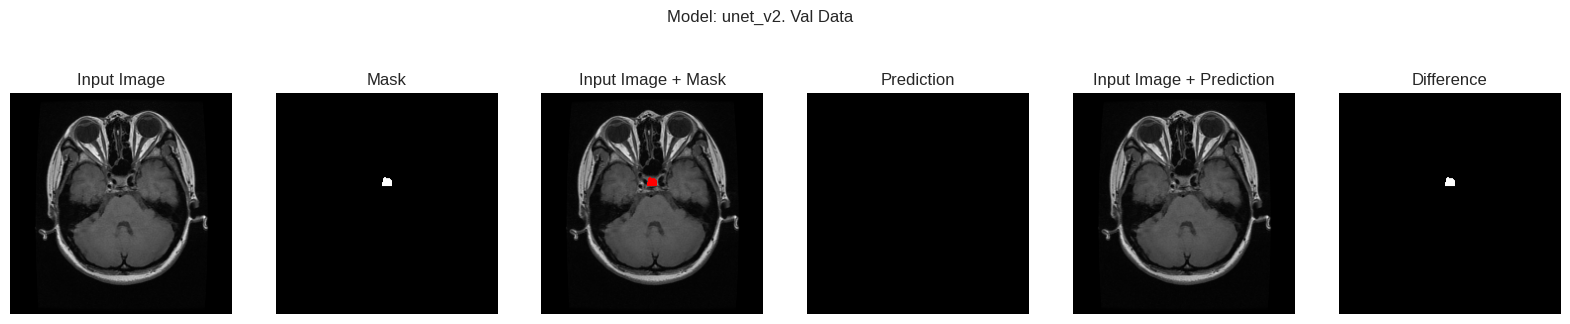

In [193]:
test_models(val_generator, "Val Data")

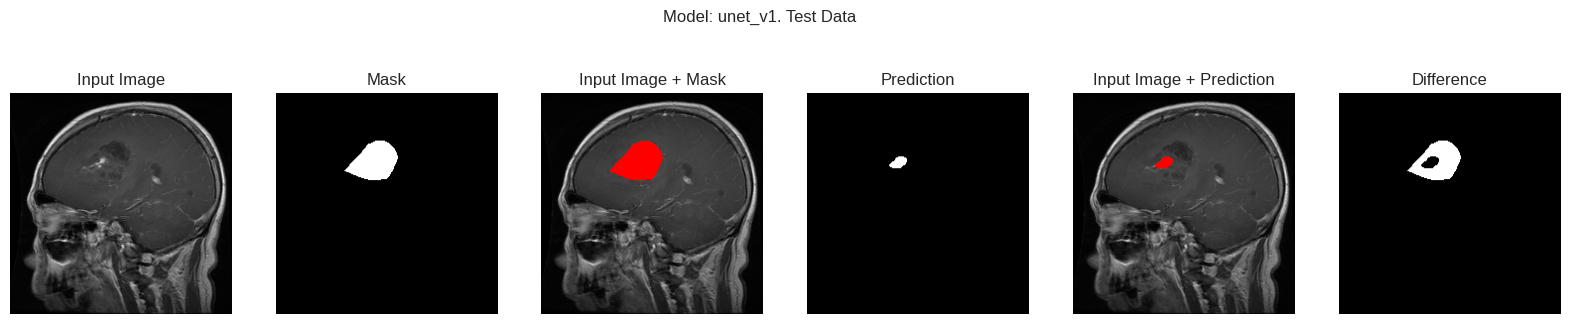

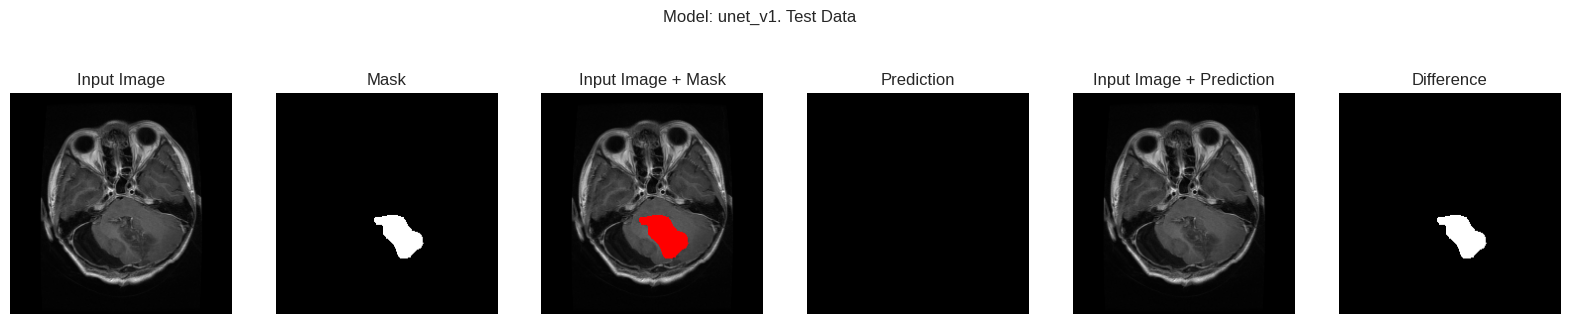

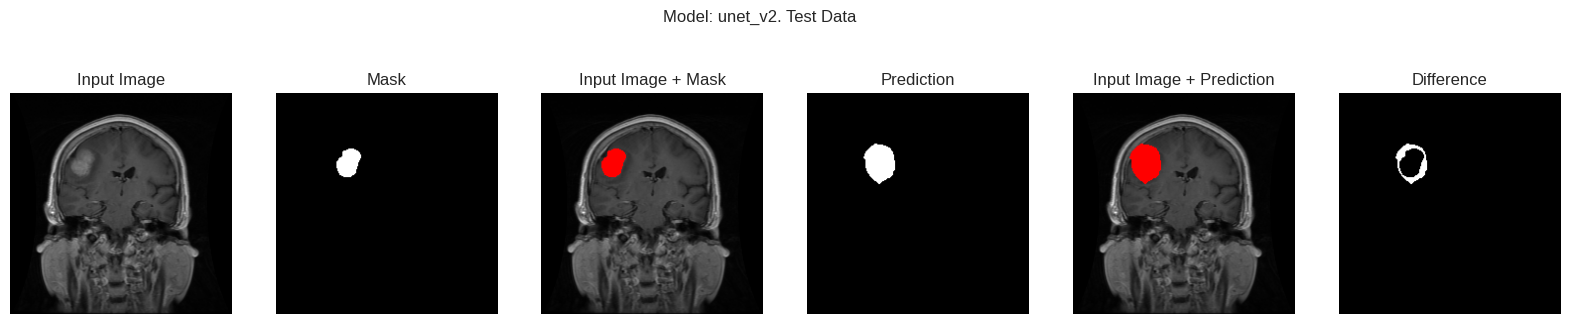

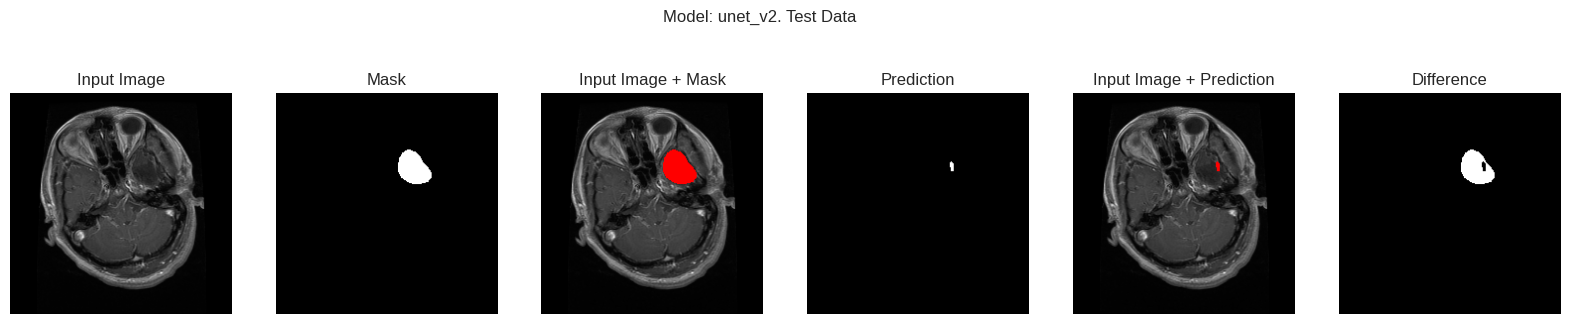

In [194]:
test_models(test_generator, "Test Data")